In [1]:
# select force data from a kymograph, correct force drift, isolate continuous force events vs background baseline
# data, then detect and quantify individual dissociation events (i.e. rapid reductions in the force) within each 
# continuous force event.

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector, Slider
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import scipy.signal as signal
from scipy.signal import savgol_filter, butter, find_peaks, peak_widths
import glob
import os
from os.path import basename, splitext, join, exists
import re
import lumicks.pylake as lk
from ctraptools.kymos.interactive import DisplayRangeSelector

#increase width of notebook:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#define gaussian for fitting to histograms:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

In [2]:
#set the directory and list the contained .h5 and .csv files
direc = r"T:\Alex Hughes Games\C-trap\2023_01_20 Avi-SauUSI H119A & WT 2 site HtH 26.2 kb DNA\H119A"
output = join(direc, 'force analysis')
if not exists(output):
    os.mkdir(output)

print('.h5 files in directory:')
for h5_file in sorted(glob.glob(join(direc,"*.h5"))):
    print(basename(h5_file))

.h5 files in directory:
20230120-131955 Kymograph 1 H119A F, trans, and diffuser collision.h5
20230120-132815 Kymograph 2 H119A only non-specific binders, same DNA as prev.h5
20230120-133802 Kymograph 3 H119A non-specific binder no trans in ATP, tether break.h5
20230120-135230 Kymograph 4 H119A trans, F.h5
20230120-135451 Kymograph 5 H119A trans, same DNA as prev.h5
20230120-135816 Kymograph 6 H119A merge, F, trans.h5
20230120-140604 Kymograph 7 H119A trans, distal F.h5
20230120-140911 Kymograph 8 H119A poss trans, then diffusion.h5
20230120-141731 Kymograph 9 H119A trans, collide.h5
20230120-142502 Kymograph 10 H119A trans, F, collide.h5


In [3]:
# paste the file to be analysed and load it into a pandas dataframe:
h5_name = '20230120-142502 Kymograph 10 H119A trans, F, collide.h5'
# to prevent excessively long file paths, just take the 'kymograph #' portion of the kymo name:
kymo_num = re.findall('kymograph ..', h5_name, re.IGNORECASE)[0]
kymo_num = 'kymo ' + re.findall('\d+',kymo_num)[0]
h5_output = join(output, kymo_num)

if not exists(h5_output):
    os.mkdir(h5_output)
h5_file = lk.File(join(direc, h5_name))

# print(h5_file) view which data channels are present in the file
# If raw force values are required, import and downsample these:
#force1x = file['Force HF']['Force 1x']
#force2x = file['Force HF']['Force 2x']
#force1y = file['Force HF']['Force 1y']
#force2y = file['Force HF']['Force 2y']
#sample_rate = force1x.sample_rate
#downsampled_rate = 10 # Hz
#force1x_downsamp = force1x.downsampled_by(int(sample_rate/downsampled_rate))
#force2x_downsamp = force2x.downsampled_by(int(sample_rate/downsampled_rate))
#force1y_downsamp = force1y.downsampled_by(int(sample_rate/downsampled_rate))
#force2y_downsamp = force2y.downsampled_by(int(sample_rate/downsampled_rate))

raw_data = pd.DataFrame()
raw_data['# Timestamps (ns)'] = h5_file['Force LF']['Trap 2'].timestamps
raw_data['Trap 1'] = h5_file['Force LF']['Trap 1'].data
raw_data['Trap 2'] = h5_file['Force LF']['Trap 2'].data
raw_data['Distance 1'] = h5_file['Distance']['Distance 1'].data

#add relative time (s) column:
raw_data['Time (s)'] = (raw_data['# Timestamps (ns)'] - raw_data['# Timestamps (ns)'][0])/1000000000
t_interval = raw_data['Time (s)'][1] - raw_data['Time (s)'][0] #calculate the time interval between data points

raw_data

,# Timestamps (ns),Trap 1,Trap 2,Distance 1,Time (s)
0,1674224702421155800,2.131602,6.894089,8.595281,0.000000
1,1674224702487818200,2.068793,6.909462,8.596138,0.066662
2,1674224702554480600,2.116097,6.807617,8.590131,0.133325
3,1674224702621143000,2.057764,7.070685,8.593578,0.199987
4,1674224702687805400,1.912080,6.981018,8.595514,0.266650
...,...,...,...,...,...
2309,1674224856344637400,2.156632,6.523060,8.594469,153.923482
2310,1674224856411299800,2.360827,6.463205,8.591539,153.990144
2311,1674224856477962200,1.967063,6.501614,8.593096,154.056806
2312,1674224856544624600,2.206179,6.555688,8.596650,154.123469


<IPython.core.display.Javascript object>


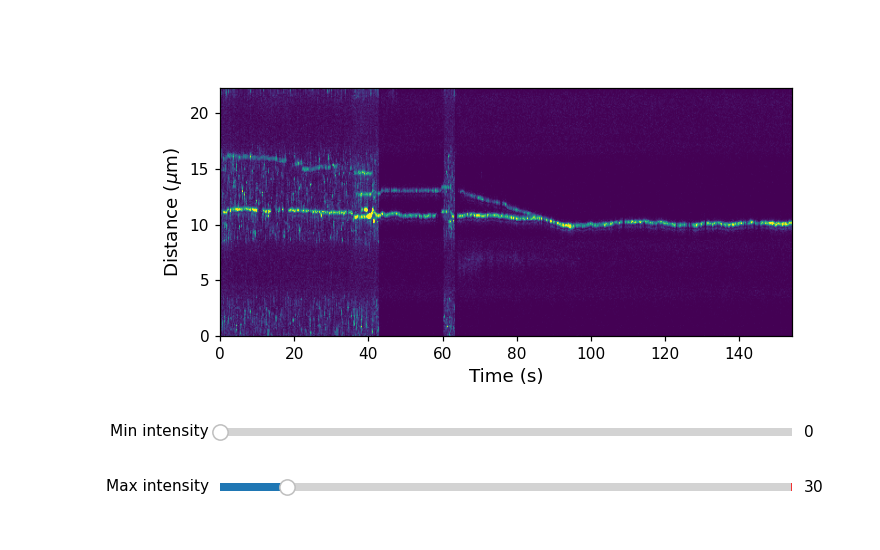

In [4]:
%matplotlib notebook
#Plot uncropped kymo and tweak intensity thresholds for a clear image.  
#To do:make updateable spanselector dual kymo plot
kymo_name = list(h5_file.kymos)[0]
kymo = h5_file.kymos[kymo_name]
kymo_line_length = kymo.size_um[0]
raw_kymo = kymo.get_image(channel='red')

#set limits to scale intensity:
drs = DisplayRangeSelector(kymo)

<IPython.core.display.Javascript object>


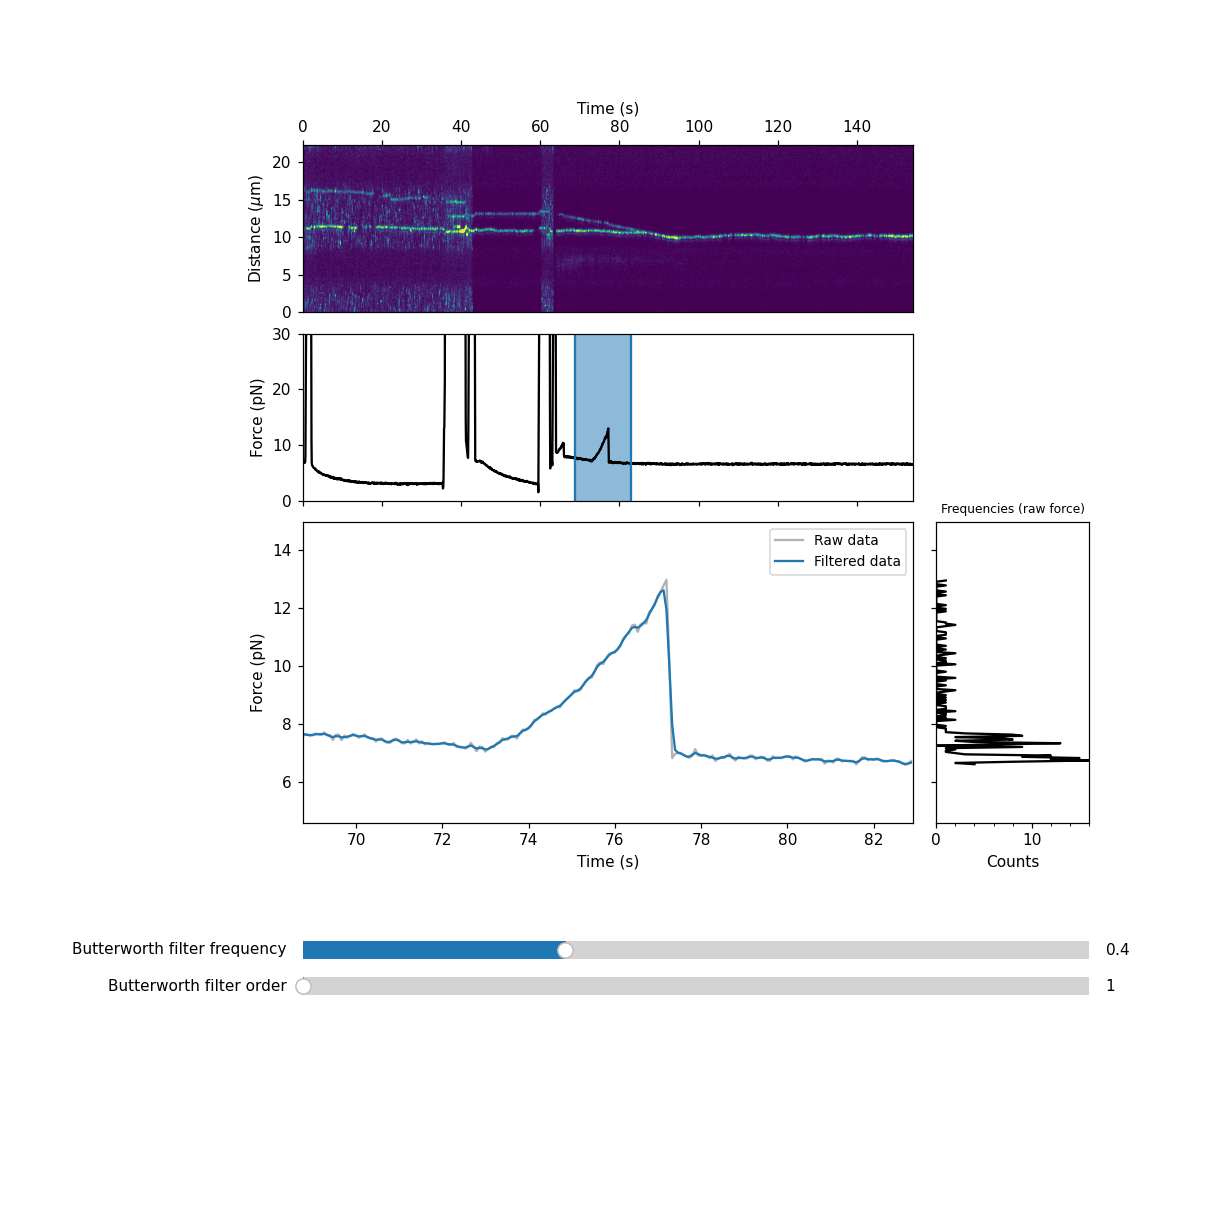

In [15]:
#slice data to time region of interest and filter to reduce noise before calculating derivatives:
%matplotlib notebook

(px_min, px_max) = drs.get_range()

F_ch = 'Trap 2'  # PICK A FORCE CHANNEL FOR ANALYSIS

#initialise filtered data column in dataframe:
butter_order =  1
butter_freq = 0.4

sos = butter(butter_order, butter_freq, 'lp', output='sos')
raw_data['Filtered force'] =  signal.sosfiltfilt(sos, raw_data[F_ch])

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11, 11), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 1, 1.8]})
fig.subplots_adjust(hspace=0.1, wspace=0.06)

ax1.imshow(raw_kymo, cmap='viridis', aspect='auto',
           extent=[raw_data['Time (s)'].min(), raw_data['Time (s)'].max(), 0, kymo_line_length],
           norm=mpl.colors.Normalize(vmin=px_min, vmax=px_max, clip=False))
ax1.set_ylabel('Distance ($\mu$m)')
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.set_xlabel("Time (s)")  
ax1.xaxis.set_label_position('top') 
#ax1.xaxis.tick_top()

ax2.axis('off')

ax3.plot(raw_data['Time (s)'], raw_data[F_ch], color='black')
#ax3.set_title('Crop data by click/dragging to select a region in the upper plot', fontsize=10)
ax3.set_ylim(0, 30) # set force axis range manually since most protein-induced forces will be low relative to drag forces from buffer flow or bead displacements.
ax3.set_ylabel("Force (pN)")

ax3.get_shared_x_axes().join(ax1, ax3)
ax3.set_xticklabels([])

ax4.axis('off')

ax5.set_xlabel("Time (s)")
ax5.set_ylabel("Force (pN)")
ax6.set_xlabel("Counts")
ax6.set_title('Frequencies (raw force)', fontsize=8)

ax6.get_shared_y_axes().join(ax5, ax6)
ax6.set_yticklabels([])
ax6.minorticks_on()
ax6.yaxis.set_tick_params(which='minor', bottom=False)

plot2, = ax5.plot([], [], label='Raw data', color='black', alpha=.3)
plot3, = ax5.plot([], [], label='Filtered data')

plot4, = ax6.plot([], [], color='black') #I'm not sure how to make an active histogram or bar plot, so doing this as a normal plt.plot()

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.32)

# Make a horizontal slider to set the filter frequency:
init_freq = 0.4

ax_freq = fig.add_axes([0.25, 0.2, 0.65, 0.03])
freq_slider = Slider(
    ax=ax_freq,
    label='Butterworth filter frequency',
    valmin=0.1,
    valmax=1,
    valinit=init_freq,
    valstep=0.05
)

# Make a horizontal slider to set the filter order:
init_order = 1
ax_order = fig.add_axes([0.25, 0.17, 0.65, 0.03])
order_slider = Slider(
    ax=ax_order,
    label='Butterworth filter order',
    valmin=1,
    valmax=20,
    valinit=init_order,
    valstep=1
)

def onselect(xmin, xmax):
    sos = butter(butter_order, butter_freq, 'lp', output='sos')
    raw_data['Filtered force'] =  signal.sosfiltfilt(sos, raw_data[F_ch])
    global data
    data = raw_data.loc[(raw_data['Time (s)'] > xmin) & (raw_data['Time (s)'] < xmax)]

    region_x = data['Time (s)']
    region_y = data[F_ch]
    region_y2 = data['Filtered force']
    
    global counts, bins
    counts, bins = np.histogram(data[F_ch], bins=150)
    global bin_mids
    bin_mids = (bins[1:] + bins[:-1])/2

    if len(region_x) >= 2:
        plot2.set_data(region_x, region_y)
        ax5.set_xlim(xmin, xmax)
        ax5.set_ylim(data[F_ch].min()-2, data[F_ch].max()+2)
        ax5.legend(fontsize=9)
        plot3.set_data(region_x, region_y2)
        
        ax6.set_xlim(0, counts.max())
        plot4.set_data(counts, bin_mids)
        fig.canvas.draw_idle()

span = SpanSelector(
    ax3,
    onselect,
    "horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    drag_from_anywhere=True
)
# Set useblit=True on most backends for enhanced performance.

# The functions to be called anytime a slider's value changes 
def update_freq(val):
    global butter_freq
    butter_freq = val
    sos = butter(butter_order, butter_freq, 'lp', output='sos')
    data['Filtered force'] = signal.sosfiltfilt(sos, data[F_ch])
    region_x = data['Time (s)']
    region_y2 = data['Filtered force']
    plot3.set_data(region_x, region_y2)
    fig.canvas.draw_idle()
    
    global init_freq
    init_freq = val
    
def update_order(val):
    global butter_order
    butter_order = val   
    sos = butter(butter_order, butter_freq, 'lp', output='sos')
    data['Filtered force'] = signal.sosfiltfilt(sos, data[F_ch])
    region_x = data['Time (s)']
    region_y2 = data['Filtered force']
    plot3.set_data(region_x, region_y2)
    fig.canvas.draw_idle()
    
    global init_order
    init_order = val

freq_slider.on_changed(update_freq)
order_slider.on_changed(update_order)

plt.show()

In [6]:
# determine the true baseline force from the initial region of the kymograph in the channel where
# it was first set. Do this by selecting the appropriate region in the interactive data cropper above
# then calculating the mean force value

true_baseline = np.mean(data['Trap 2']) #assign the real baseline value in pN
print(true_baseline)

#then select the data region for analysis

3.0816945469848496


<IPython.core.display.Javascript object>


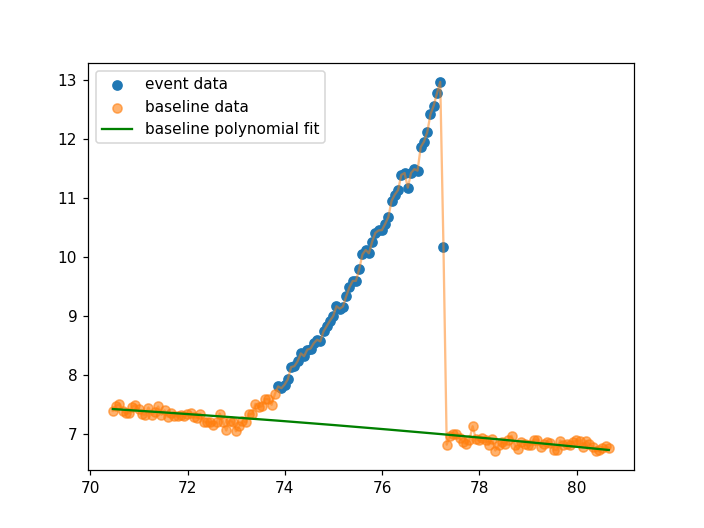

C:\Users\ah9473\AppData\Local\Temp\ipykernel_13700\426094299.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trap 2 corrected'] = true_baseline + (data['Trap 2'] - for_subtraction)
C:\Users\ah9473\AppData\Local\Temp\ipykernel_13700\426094299.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trap 2 relative'] = (data['Trap 2'] - for_subtraction)


<IPython.core.display.Javascript object>


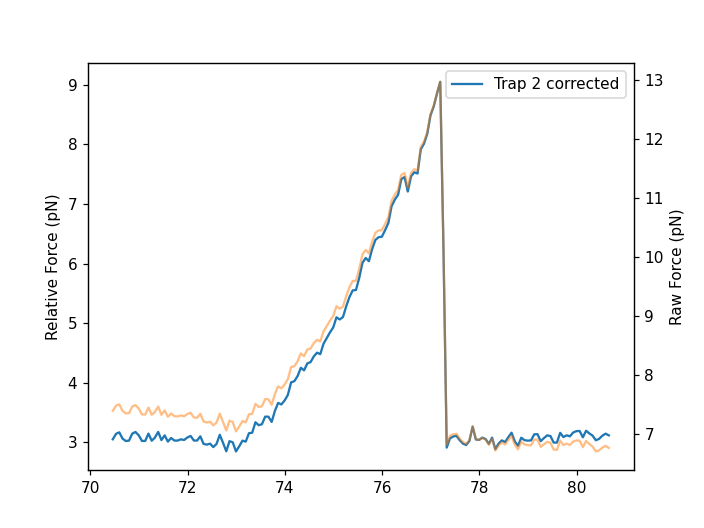

<IPython.core.display.Javascript object>


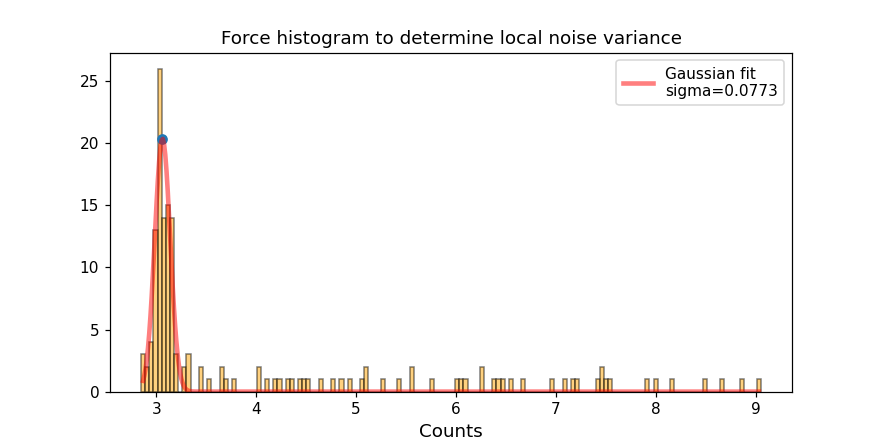

In [14]:
# Correct baseline drift.
# Then calculate the standard deviation of baseline noise to determine statistically significant events.
plt.close()

cutoff = 0.16 # e.g. 0.1 means the lower 10% of data wil be considered background and used for drift correction.
# It would be nice to select this cutoff value via a slider on an interactive plot widget, which could then 
# display the before/after correction plots and Gaussian fit to the baseline noise.

F_min = data['Trap 2'].min()
F_max = data['Trap 2'].max()
F_range = F_max - F_min 

event_data = data.loc[data['Trap 2']>= F_min + cutoff*F_range]  #consider events to be only data points above min + cutoff*range.
baseline_data = data.loc[data['Trap 2']< F_min + cutoff*F_range]

t_min = baseline_data['Time (s)'].min()
t_max = baseline_data['Time (s)'].max()

#fit polynomial to baseline data
poly = Polynomial.fit(baseline_data['Time (s)'], baseline_data['Trap 2'], 2)
x = np.arange(t_min, t_max, 0.2)

#evaluate this polynomial at every timepoint
for_subtraction = poly(data['Time (s)'])

plt.plot(data['Time (s)'], data['Trap 2'], alpha=.5, color='tab:orange')
plt.scatter(event_data['Time (s)'], event_data['Trap 2'], label='event data')
plt.scatter(baseline_data['Time (s)'], baseline_data['Trap 2'], label='baseline data', alpha=.6)
plt.plot(data['Time (s)'], for_subtraction, color='green', label ='baseline polynomial fit')
#plt.scatter([in_t, out_t], [in_f, out_f])
plt.legend()
plt.show()

# apply the drift correction
data['Trap 2 corrected'] = true_baseline + (data['Trap 2'] - for_subtraction)
data['Trap 2 relative'] = (data['Trap 2'] - for_subtraction)

fig, ax1 = plt.subplots()
ax1.plot(data['Time (s)'], data['Trap 2 corrected'], label='Trap 2 corrected')
ax1.set_ylabel("Relative Force (pN)")
ax2 = ax1.twinx()
ax2.plot(data['Time (s)'], data['Trap 2'], alpha=.5, color='tab:orange')
ax2.set_ylabel("Raw Force (pN)")
ax1.legend()

plt.show()


#get the SD of local baseline noise

plt.figure(figsize=(8,4))

bins = 150
force_hist = plt.hist(data['Trap 2 corrected'], bins=bins, edgecolor="black", facecolor='orange', alpha=.5)
count = force_hist[0]
bins = force_hist[1]
bin_mids = (bins[1:] + bins[:-1])/2

#fit histogram with gaussian
params, cov = curve_fit(gauss, bin_mids, count) # use this line if estimates are required
mu = params[0]
sigma = params[1]
local_baseline_sd = abs(sigma)
x_fit = np.linspace(bin_mids.min(), bin_mids.max(), 500)

plt.plot(x_fit, gauss(x_fit, *params), color='red', lw=3, label='Gaussian fit \nsigma='+str(round(local_baseline_sd, 4)), alpha = 0.5)
plt.scatter(mu, gauss(mu, *params))
plt.xlabel("Counts", fontsize = 12)
plt.title('Force histogram to determine local noise variance')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


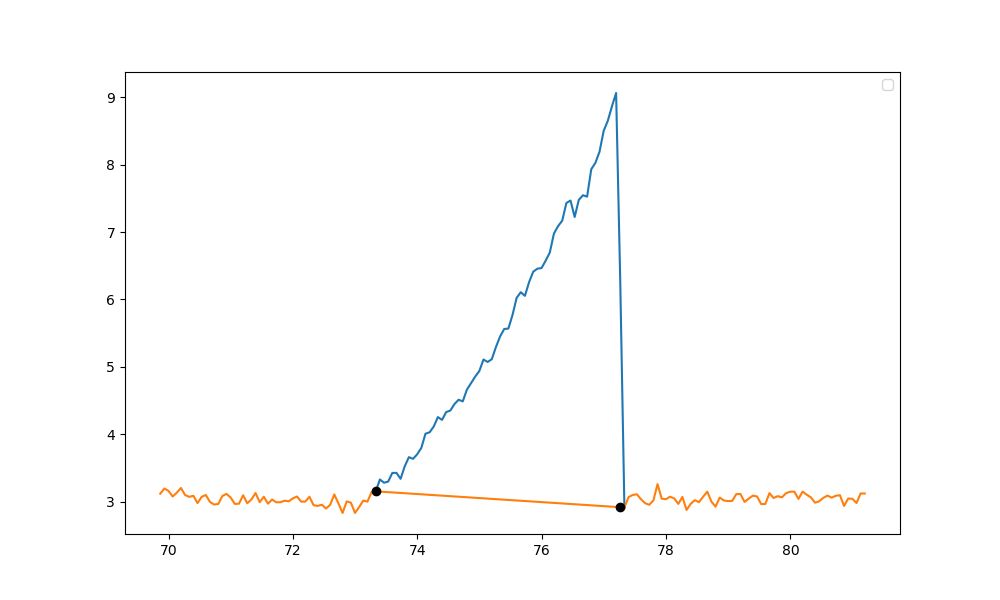

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\ah9473\AppData\Local\Temp\ipykernel_16112\3661765372.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Relative time (s)'] = data['Time (s)'] - in_t


In [39]:
# having established the baseline and corrected drift, now redefine the start and end points of each force event as the 
# times at which the force initially rises to sigma_mult*SD above the baseline, and returns to sigma_mult*SD above the baseline.
sigma_mult = 2.7
cutoff = true_baseline + sigma_mult*local_baseline_sd

for i, t in enumerate(data['Time (s)'].iloc[:-1]):
    f_val1 = data['Trap 2 corrected'].iloc[i]
    f_val2 = data['Trap 2 corrected'].iloc[i+1]
    if (f_val1 < cutoff) and (f_val2 > cutoff):
        in_id = i
        in_t = t 
        in_f = f_val1
    if (f_val1 >= cutoff) and (f_val2 < cutoff):
        out_id = i+1
        out_t = t
        out_f = f_val2

event_data = data.iloc[in_id:out_id+1] #this approach will tend to exclude the first few data points of the event,
# including some points preceding the cutoff crossover may help, but should really be a factor of the time resolution.

baseline_data = data.loc[data['Trap 2 corrected'] < cutoff]

plt.figure(figsize=(10,6))
plt.scatter([in_t, out_t], [in_f, out_f], color='black', zorder=10) #set zorder high to bring this scatter plot to the front
plt.plot(event_data['Time (s)'], event_data['Trap 2 corrected'])
plt.plot(baseline_data['Time (s)'], baseline_data['Trap 2 corrected'])
plt.legend()
plt.show()

# add a relative time column with the first event time as t=0
# different force events can then be overlayed with roughly aligned start points.
data['Relative time (s)'] = data['Time (s)'] - in_t

C:\Users\ah9473\AppData\Local\Temp\ipykernel_16112\2293475068.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Force (pN)'] = data['Trap 2 corrected']
C:\Users\ah9473\AppData\Local\Temp\ipykernel_16112\2293475068.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dF/dt'] = dF_dt
C:\Users\ah9473\AppData\Local\Temp\ipykernel_16112\2293475068.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

<IPython.core.display.Javascript object>


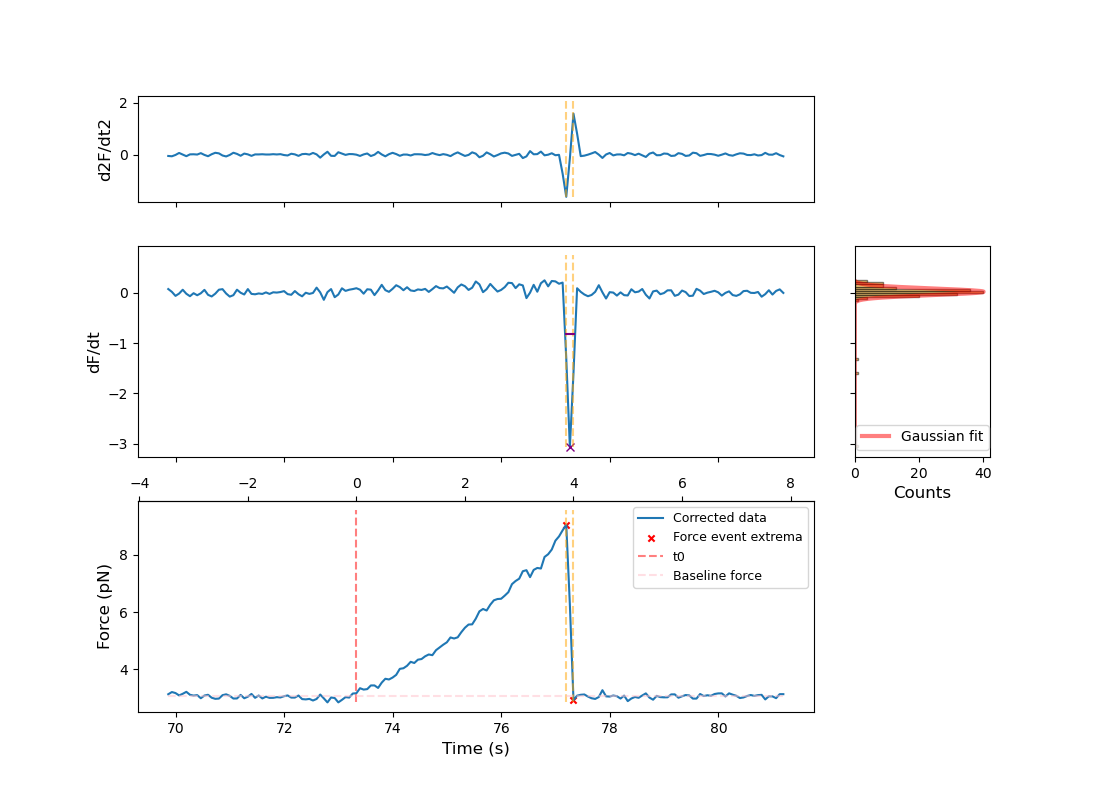

In [40]:
%matplotlib notebook
#Detect significant force reduction events (e.g. loop breaking) via dF/dt, then determine their boundaries via d2F/dt2.
#Export the before/after force values to a .csv

# depending on signal/noise and which dissociation events are of interest etc. the dF/dt peakfinding
# may need to be refined with several of the following parameters, however, in many cases the peak 
# height parameter alone is sufficient.
h_sigma_mult = 2.5 #SET SD MULTIPLIER FOR PEAK FINDER HEIGHT THRESHOLD height=h_cutoff
p_sigma_mult = 2.5 #OPTIONAL: SET SD MULTIPLIER FOR PEAK FINDER PROMINENCE THRESHOLD WITH prominence=p_cutoff
peak_dist = 8 # OPTIONAL: SET MINIMAL DISTANCE ALLOWED BETWEEN ADJACENT dF/dt PEAKS WITH distance=peak_dist
peak_width = [0.4, 5] # OPTIONAL: SET ALLOWED RANGE OF PEAK WIDTHS FOR PEAK FINDER WITH width=peak_width

# Select the channel to be used for calculating gradients
data['Force (pN)'] = data['Trap 2 corrected']

#calculate the derivative of Force data using np.gradient:
dF_dt = np.gradient(data['Force (pN)'])
data['dF/dt'] = dF_dt

#reorder dataframe columns to tidy things up:
data = data[['# Timestamps (ns)', 'Time (s)', 'Relative time (s)', 'Distance 1', 'Trap 1', 'Trap 2', 'Filtered force', 'Trap 2 corrected', 'Trap 2 relative', 'Force (pN)', 'dF/dt']]

#calculate histogram bin counts of dF_dt values:
dF_dt_hist = np.histogram(data['dF/dt'], bins=80)
count = dF_dt_hist[0]
bins = dF_dt_hist[1]
bin_mids = (bins[1:] + bins[:-1])/2

#fit histogram with gaussian
params, cov = curve_fit(gauss, bin_mids, count) 
mu = params[0]
sigma = abs(params[1])
x_fit = np.linspace(bin_mids.min(), bin_mids.max(), 500)

#identify peaks above a threshold based on the noise gradient distribution:
dF_dt_np = data['dF/dt'].to_numpy() #convert to numpy array for find_peaks

h_cutoff = abs(mu - (h_sigma_mult*sigma)) #SET CUTOFF FOR dF/dt PEAK HEIGHTS
p_cutoff = abs(mu - (p_sigma_mult*sigma)) #SET CUTOFF FOR dF/dt PEAK PROMINENCES

#NB 'wlen' is optional and limits the window used for peak prominence calculations:
peaks_t, peak_params = find_peaks(-dF_dt_np, height=h_cutoff, wlen=10) #OPTIONAL ARGS: prominence=p_cutoff, distance=peak_dist, width=peak_width
#peaks_t only gives the 'positions' of peaks in the array, rather than actual time values, so need to convert to seconds:
peaks_t_sec = data['Time (s)'].iloc[0] + (peaks_t * t_interval)
peaks_t_sec_rel = data['Relative time (s)'].iloc[0] + (peaks_t * t_interval) #also get the event times relative to t0
widths = peak_widths(-dF_dt_np, peaks_t, rel_height=0.7) #detect start/end end positions used to calculate peak widths
#get the times corresponding to the bases of each peak:
#left_bases = peak_params.get('left_bases')
#right_bases = peak_params.get('right_bases')
#left_bases_t = data['Time (s)'].iloc[0] + (peak_params.get('left_bases')  * t_interval) 
#right_bases_t = data['Time (s)'].iloc[0] + (peak_params.get('right_bases')  * t_interval)


#NB Trap 2 data is not perfectly aligned in time with Distance 1 data! So need to separately detect local max/min of d2D/dt2 for smoothed distance.
d2F_dt2 = np.gradient(data['dF/dt'])
data['d2F/dt2'] = d2F_dt2


crop_width = 0.4 #width (in seconds) of region flanking peak to be used for finding max and min d2F/dt2
slip_in_outs = []
slip_in_outs_rel = []
slip_pre_post_force = []
slip_pre_post_force_rel = []

for i, times in enumerate(peaks_t_sec):
    data_crop = data.loc[(data['Time (s)'] > peaks_t_sec[i] - (crop_width/2)) & (data['Time (s)'] < peaks_t_sec[i] + (crop_width/2))]

    max_index = data_crop['d2F/dt2'].idxmax() #find index of the maximum d2F/dt2 value
    min_index = data_crop['d2F/dt2'].idxmin()
    max_t = data_crop['Time (s)'].loc[max_index] #set the time corresponding to the max d2F/dt2 value
    min_t = data_crop['Time (s)'].loc[min_index]
    max_t_rel = data_crop['Relative time (s)'].loc[max_index] #set the (relative) time corresponding to the max d2F/dt2 value
    min_t_rel = data_crop['Relative time (s)'].loc[min_index]
    slip_in_outs.append([min_t, max_t])
    slip_in_outs_rel.append([min_t_rel, max_t_rel])
    
    pre_force_abs = data_crop['Trap 2 corrected'].loc[min_index] #The absolute value of force immediately before a force event
    post_force_abs = data_crop['Trap 2 corrected'].loc[max_index]
    slip_pre_post_force.append([pre_force_abs, post_force_abs]) #NB, taking these values from Trap 2 force
    
    pre_force_rel = data_crop['Trap 2 corrected'].loc[min_index] - true_baseline #The value of force immediately before a force event
    post_force_rel = data_crop['Trap 2 corrected'].loc[max_index] - true_baseline
    slip_pre_post_force_rel.append([pre_force_rel, post_force_rel])
    
    max_d2F_dt2 = data_crop['d2F/dt2'].loc[max_index]
    min_d2F_dt2 = data_crop['d2F/dt2'].loc[min_index]
    
force_diffs = [x[0] - x[1] for x in slip_pre_post_force] #calculate the differences between forces immdiately before/after force events.

# Create a pandas DataFrame containing the force event data:
slip_in_outs_trans = list(map(list, zip(*slip_in_outs))) #transpose to get all 'event in'/'event out' times on the same row
slip_in_outs_rel_trans = list(map(list, zip(*slip_in_outs_rel)))
slip_pre_post_force_trans = list(map(list, zip(*slip_pre_post_force)))
slip_pre_post_force_rel_trans = list(map(list, zip(*slip_pre_post_force_rel)))

d = {'Event in time (s)': slip_in_outs_trans[0],
     'Event out time (s)': slip_in_outs_trans[1],
     'Event in time rel (s)': slip_in_outs_rel_trans[0],
     'Event out time rel (s)': slip_in_outs_rel_trans[1],
     'Pre-event force abs (pN)': slip_pre_post_force_trans[0],
     'Post-event force abs (pN)': slip_pre_post_force_trans[1],
     'Pre-event force rel (pN)': slip_pre_post_force_rel_trans[0],
     'Post-event force rel (pN)': slip_pre_post_force_rel_trans[1],
     'Force difference (pN)': force_diffs}

force_events = pd.DataFrame(d)

        
#Plot Force, dF/dt, and d2F/dt2 in one subplot figure:

#Here, the subplots axes are created first, then populated with plots, and their axes linked via e.g. ax1.get_shared_x_axes().join(ax1, ax5)
#This doesn't remove the tick labels from the linked axes, so they need to be manually hidden with ax1.set_xticklabels([])

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11,8), gridspec_kw={'width_ratios': [5, 1], 'height_ratios': [1, 2, 2]})
ax_font_size = 12
ax_tick_size = 10

ax1.plot(data['Time (s)'], data['d2F/dt2'])
ax1.set_ylabel("d2F/dt2", fontsize = ax_font_size)
ax1.vlines(slip_in_outs, ymin = data['d2F/dt2'].min(), ymax = data['d2F/dt2'].max()+0.5, color="orange", alpha=0.5, linestyles='dashed')
ax1.yaxis.set_tick_params(labelsize=ax_tick_size)

ax1.get_shared_x_axes().join(ax1, ax5)
ax1.set_xticklabels([])

ax2.axis('off')

color = 'tab:blue'
ax3.set_ylabel('dF/dt', fontsize = ax_font_size)
ax3.plot(data['Time (s)'], data['dF/dt'], color = color)
ax3.plot(peaks_t_sec, dF_dt_np[peaks_t], "x", color="purple")
#ax3.plot(left_bases_t, dF_dt_np[left_bases], 'x', color='green')
#ax3.plot(right_bases_t, dF_dt_np[right_bases], '.', color='green')
ax3.vlines(slip_in_outs, ymin = data['dF/dt'].min(), ymax = data['dF/dt'].max()+0.5, color="orange", alpha=0.5, linestyles='dashed')
ax3.yaxis.set_tick_params(labelsize=ax_tick_size)

ax3.get_shared_x_axes().join(ax3, ax5)
ax3.set_xticklabels([])

widths_start_sec = data['Time (s)'].iloc[0] + (widths[2] * t_interval)
widths_end_sec = data['Time (s)'].iloc[0] + (widths[3] * t_interval)
ax3.hlines(-widths[1], widths_start_sec, widths_end_sec, color="purple")

ax4.plot(gauss(x_fit, *params), x_fit, color='red', lw=3, label='Gaussian fit', alpha = 0.5)
ax4.hist(data['dF/dt'], bins=bins, edgecolor = "black", facecolor = 'orange', alpha = 0.5, orientation='horizontal')
ax4.set_xlabel("Counts", fontsize = ax_font_size)
ax4.xaxis.set_tick_params(labelsize=ax_tick_size)
ax4.grid(False)
ax4.legend(loc='lower center')

ax4.get_shared_y_axes().join(ax3, ax4)
ax4.set_yticklabels([])

ax5.plot(data['Time (s)'], data['Force (pN)'], label='Corrected data')
#ax5.plot(data['Time (s)'], data[F_ch], color='tab:blue', alpha=0.3, label='Raw data')
ax5.scatter(sum(slip_in_outs, []), sum(slip_pre_post_force, []), label="Force event extrema", s=20.0, marker='x', color='red') #'sum' is used here to flatten the tuples into a single list
ax5.set_xlabel('Time (s)', fontsize = ax_font_size)
ax5.set_ylabel("Force (pN)", fontsize = ax_font_size)
ax5.vlines(slip_in_outs, ymin = data['Force (pN)'].min(), ymax = data['Force (pN)'].max()+0.5, color="orange", alpha=0.5, linestyles='dashed')
ax5.vlines(in_t, ymin = data['Force (pN)'].min(), ymax = data['Force (pN)'].max()+0.5, color="red", alpha=0.5, linestyles='dashed', label='t0')
ax5.hlines(true_baseline, xmin = data['Time (s)'].min(), xmax = data['Time (s)'].max(), color="pink", alpha=0.5, linestyles='dashed', label='Baseline force')
ax5.xaxis.set_tick_params(labelsize=ax_tick_size)
ax5.yaxis.set_tick_params(labelsize=ax_tick_size)
secax = ax5.secondary_xaxis('top', functions=(lambda x: x-in_t, lambda x: x+in_t)) #add second axis with baseline-adjusted force
ax5.legend(fontsize=9)

ax6.axis('off')

fig.subplots_adjust(hspace=0.25, wspace=0.1)
#fig.tight_layout()
plt.show()

In [41]:
# Once happy with the detected events, export data for the selected region:
# Include the start and end times of the selected region in the file name

start = round(data['Time (s)'].iloc[0], 2) #round time to 2 decimal places to avoid clunky file names
start = str(start) #get string of region start time
start = start.replace('.', '_') #replace period character so it isn't mistaken for a file extension indicator
end = round(data['Time (s)'].iloc[-1], 2)
end = str(end)
end = end.replace('.', '_')

prefix = '('+start+'-'+end+' s) ' + F_ch #file prefix indicating the time region analysed
data['Baseline force (pN)'] = true_baseline #add a column containing the baseline tether force value.
data.to_csv(join(h5_output, prefix + ' df.csv'), index=False)
force_events.to_csv(join(h5_output, prefix + ' event values.csv'))
fig.savefig(join(h5_output, prefix + ' plots.pdf'), bbox_inches = 'tight')